In [220]:
import numpy as np
import datetime as dt 
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [261]:
df = pd.read_csv("../EDA/gen/historical_data_1d.csv", sep=';')
df["begin"] = pd.to_datetime(df["begin"])
df_sber = df[df['name'] == 'SBER']
df_sber = df_sber.loc[df_sber['begin'] >= df_sber['begin'].max() - pd.Timedelta(days=365*2)]
df_sber.set_index('begin')

,open,close,high,low,value,volume,name
begin,,,,,,,
2023-10-16,264.00,268.15,269.20,263.51,1.434420e+10,53723180,SBER
2023-10-17,268.30,270.00,271.97,266.91,1.382585e+10,51214360,SBER
2023-10-18,270.00,267.90,271.19,266.11,1.084531e+10,40380530,SBER
2023-10-19,267.13,268.65,271.00,266.28,9.007682e+09,33532880,SBER
2023-10-20,268.50,269.80,270.30,266.50,8.836451e+09,32879730,SBER
...,...,...,...,...,...,...,...
2025-10-09,282.80,289.37,290.45,278.75,2.175614e+10,76179258,SBER
2025-10-10,289.90,285.12,289.95,284.10,9.802145e+09,34168796,SBER
2025-10-11,284.40,285.16,285.31,282.22,6.785288e+08,2386239,SBER


In [262]:
df = df_sber
symbol_name = 'SBER'

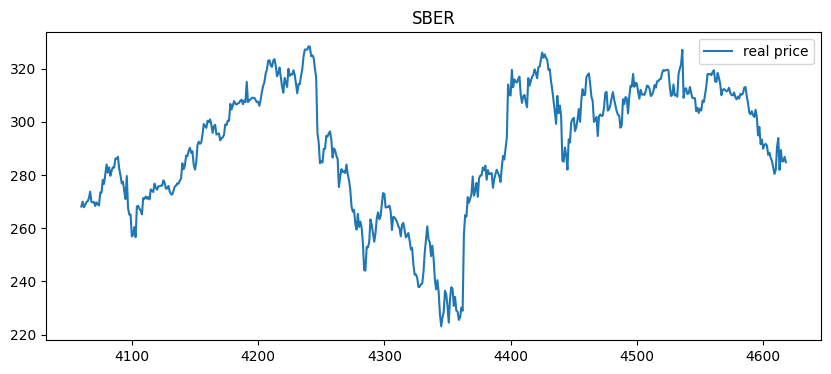

In [263]:
plt.figure(figsize=(10,4))
plt.title(symbol_name)
plt.plot(df['close'], label='real price')
plt.legend()
plt.show()

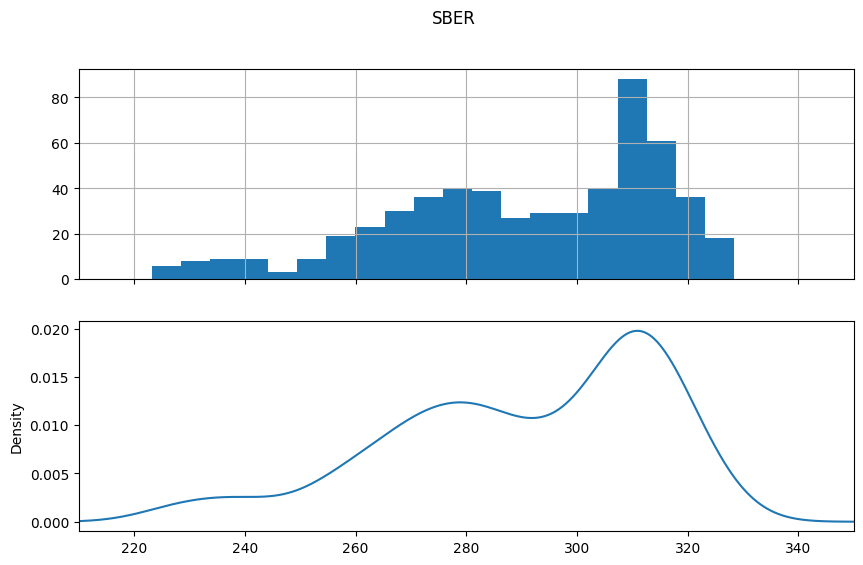

In [264]:
fig, ax = plt.subplots(2, figsize=(10,6), sharex=True)
fig.suptitle(symbol_name)
df['close'].hist(ax=ax[0], bins=20)
df['close'].plot(kind='kde', ax=ax[1])
ax[0].set_xlim([210,350])
plt.show()

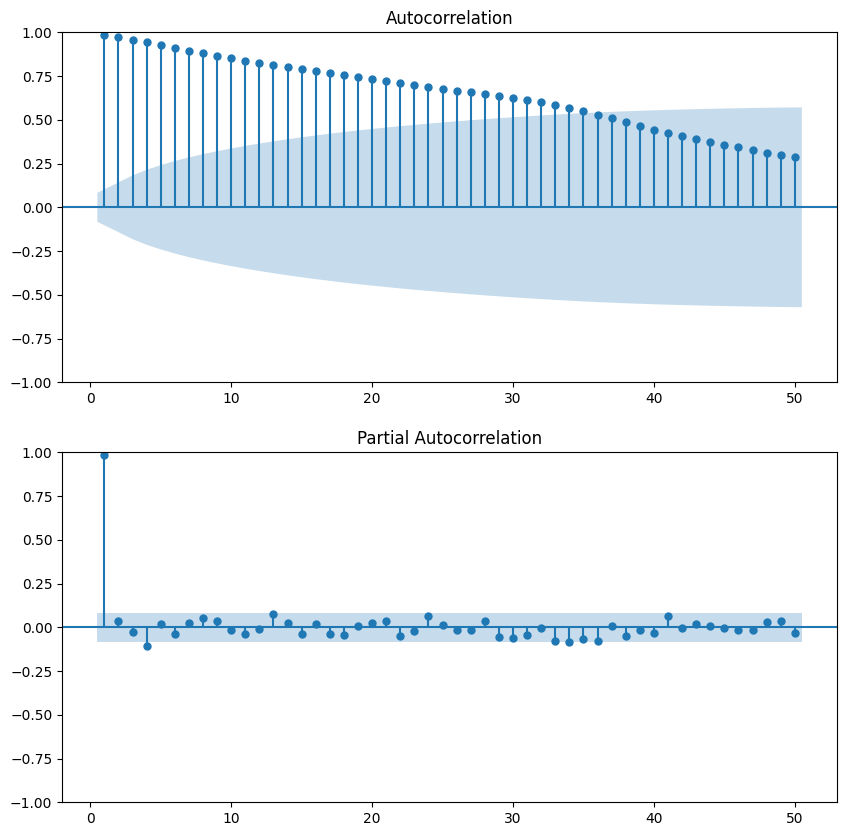

In [265]:
def plot_acf_pacf(df):
    fig, ax = plt.subplots(2, figsize=(10,10))
    plot_acf(df, lags=50, zero=False, ax=ax[0])
    plot_pacf(df, lags=50, zero=False, ax=ax[1])
    return plt.show()

plot_acf_pacf(df['close'])

ADF Statistic: -12.185850
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


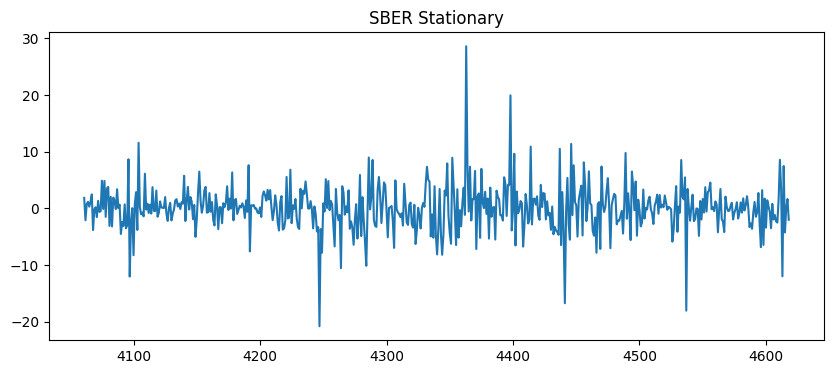

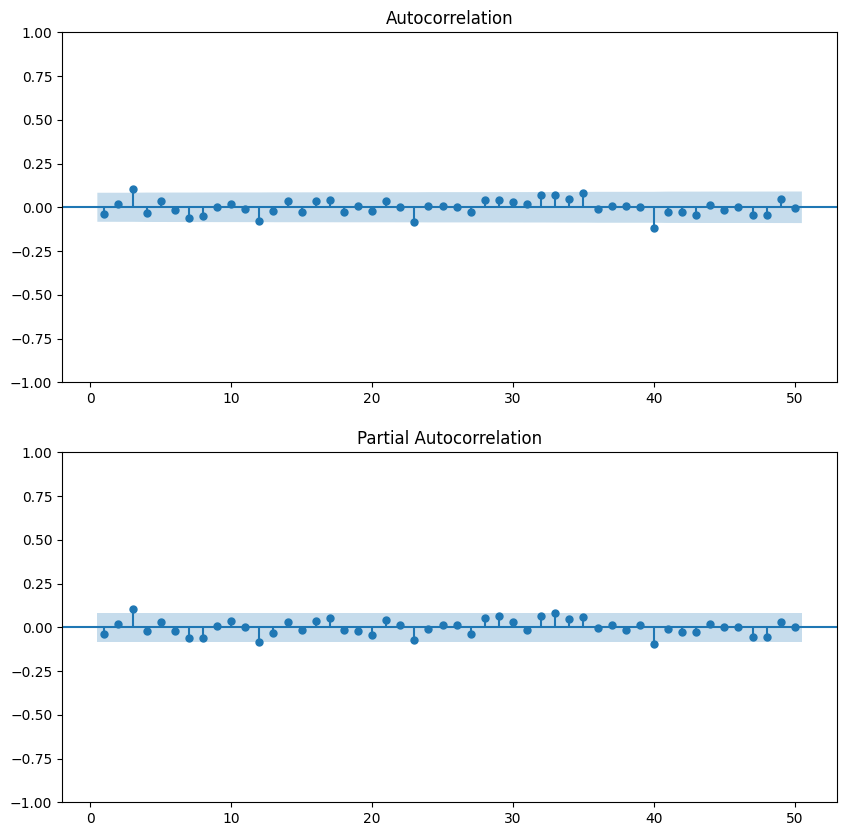

In [266]:
X = df.close
stationary = X.diff(1)
stationary.dropna(axis=0, inplace=True)

result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

stationary.plot(figsize=(10,4))
plt.title(symbol_name+' Stationary')
plt.show()

plot_acf_pacf(stationary)

In [267]:
class Arima():
    def __init__(self, df, start_p=1, start_q=1, max_p=10, max_q=10,\
        d=None, max_d=2, seasonal=False, information_criterion='aic'):
        self.df = df
        self.start_p = start_p
        self.start_q = start_q
        self.max_p = max_p
        self.max_q = max_q
        self.d = d
        self.max_d = max_d
        self.seasonal = seasonal
        self.information_criterion = information_criterion
        
        if self.d is None:
            self.d = self._auto_determine_d()
    
    def _auto_determine_d(self):
        kpss_diffs = ndiffs(self.df, alpha=0.05, test='kpss', max_d=self.max_d)
        adf_diffs = ndiffs(self.df, alpha=0.05, test='adf', max_d=self.max_d)
        return max(adf_diffs, kpss_diffs)
    
    def arima_results(self):
        results = pm.auto_arima(
            self.df,
            start_p = self.start_p,
            start_q = self.start_q,
            max_p = self.max_p,
            max_q = self.max_q,
            d = self.d,
            max_d = self.max_d,
            seasonal = self.seasonal,
            information_criterion = self.information_criterion,
            trace = True,
            error_action = 'ignore',
            suppress_warnings=True,
            stepwise = True,
            scoring = 'mse',
            n_fits=250
        )
        
        print(f"Подобранная модель: ARIMA{results.order}")
        print(f"AIC: {results.aic()}")
        
        return results
    
    def forecast(self, n_periods):
        model = self.arima_results()
        forecast = model.predict(n_periods=n_periods)
        return forecast

Train: 391, Test: 168


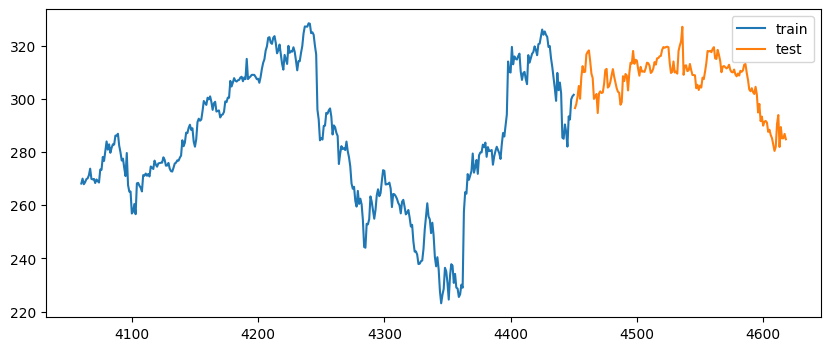

In [268]:
# Train test split
def train_test_split(X, size=0.7):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

train, test = train_test_split(X=df['close'], size=0.7)
print(f'Train: {len(train)}, Test: {len(test)}')

fig, ax = plt.subplots(figsize=(10,4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend()
plt.show()

In [269]:
arima_model = Arima(train)
results = arima_model.arima_results()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2230.264, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2226.271, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2228.271, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2228.271, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2224.435, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.131 seconds
Подобранная модель: ARIMA(0, 1, 0)
AIC: 2224.434573126069


In [270]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  391
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1111.217
Date:                Sun, 07 Dec 2025   AIC                           2224.435
Time:                        12:51:12   BIC                           2228.401
Sample:                             0   HQIC                          2226.007
                                - 391                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        17.4733      0.553     31.601      0.000      16.390      18.557
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1121.34
Prob(Q):                              0.98   Pr

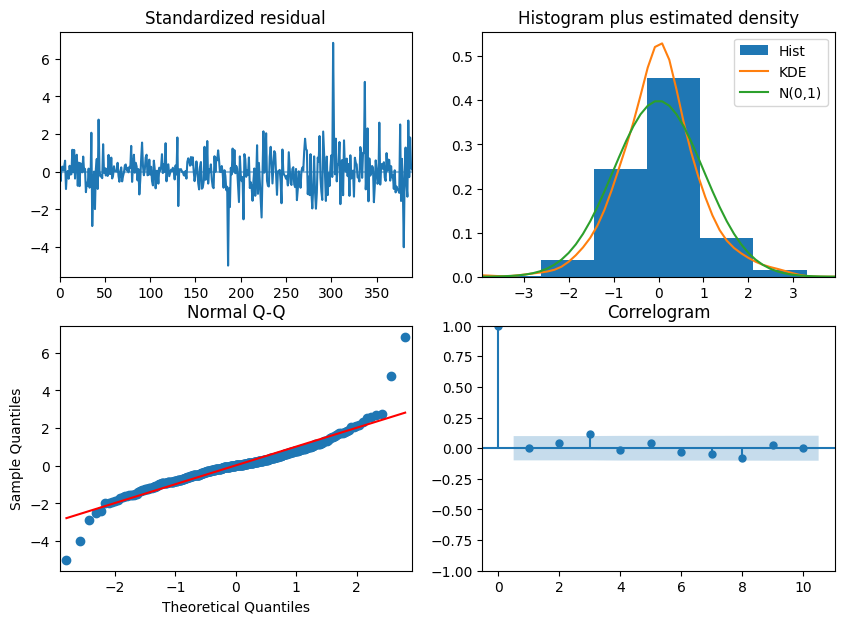

In [271]:
plot_diag = results.plot_diagnostics(figsize=(10,7))

In [272]:
predicted = results.predict(n_periods=len(test))
predicted = pd.DataFrame({'prediction': predicted.to_list()}, index=test.index)


/home/zefirka/projects/stonks/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/zefirka/projects/stonks/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



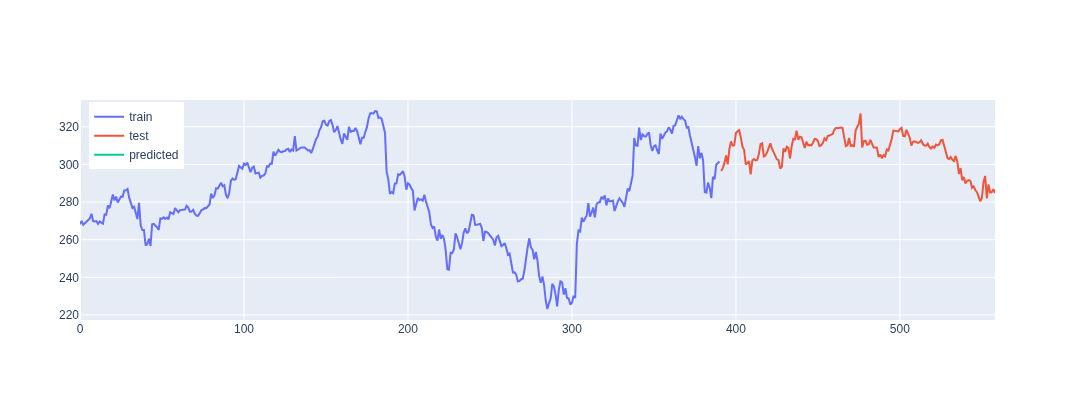

RMSE: 10.91


In [ ]:
def plot_train_test(train, test, df):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=list(range(len(train))),
        y=train,
        mode='lines',
        name='train'
    ))
    
    fig.add_trace(go.Scatter(
        x=list(range(len(train), len(train) + len(test))),
        y=test,
        mode='lines',
        name='test'
    ))
    
    fig.add_trace(go.Scatter(
        x=list(range(len(train), len(train) + len(df))),
        y=df,
        mode='lines',
        name='predicted'
    ))
    
    fig.update_layout(
        width=1000,
        height=400,
        legend=dict(x=0.01, y=0.99)
    )
    
    fig.show()

    rmse = np.sqrt(mean_squared_error(test, df))
    print(f'RMSE: {rmse:.2f}')

plot_train_test(train, test, predicted)


In [ ]:
def one_step_forecast():
    predicted, conf_int = results.predict(n_periods=1, return_conf_int=True)
    return (
        predicted.tolist()[0],
        np.asarray(conf_int).tolist()[0])

predictions = []
confidence_intervals = []

for x in test:
    predicted, conf = one_step_forecast()
    predictions.append(predicted)
    confidence_intervals.append(conf)

    results.update(x)

/home/zefirka/projects/stonks/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/zefirka/projects/stonks/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



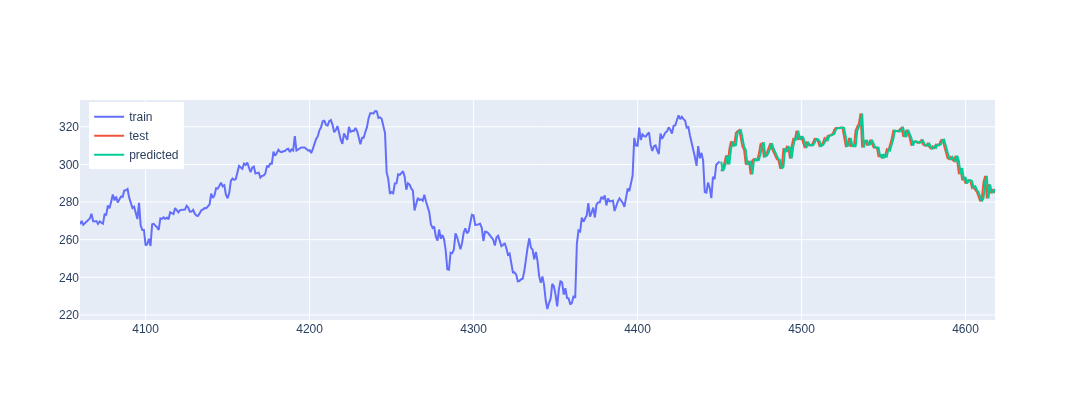

RMSE: 3.53


In [ ]:
predicted = pd.DataFrame(predictions, index=test.index, columns=['predicted'])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train.index,
    y=train.values.flatten() if hasattr(train, 'values') else train,
    mode='lines',
    name='train'
))

fig.add_trace(go.Scatter(
    x=test.index,
    y=test.values.flatten() if hasattr(test, 'values') else test,
    mode='lines',
    name='test'
))

fig.add_trace(go.Scatter(
    x=predicted.index,
    y=predicted['predicted'].values,
    mode='lines',
    name='predicted'
))

fig.update_layout(
    width=1000,
    height=400,
    legend=dict(x=0.01, y=0.99)
)

fig.show()

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.2f}')

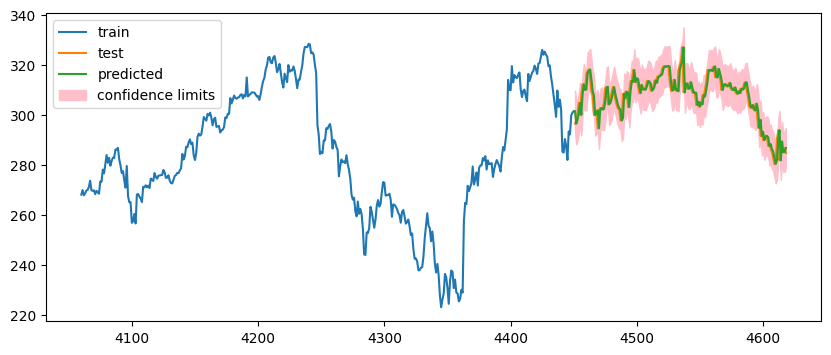

In [ ]:
lower_limits = [row[0] for row in confidence_intervals]
upper_limits = [row[1] for row in confidence_intervals]

plt.figure(figsize=(10,4))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(predicted, label='predicted')
plt.fill_between(test.index, lower_limits,
		 upper_limits, color='pink', label='confidence limits')
plt.legend()
plt.show()